# Lagrangian Jacobian optimization

## Import statements

In [1]:
%load_ext autoreload
%autoreload 2

# 3rd party imports
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
np.set_printoptions(linewidth=1000)
from scipy.sparse.linalg import lgmres
import sympy as sp


# Local imports
import modules.laplacian as laplacian
import modules.jacobian as jacobian

## Set up A $\phi$ = B case
Set up an example A*$\phi$ = B problem where there are negative Jacobian determinant values

fdata.shape (2, 5, 5)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.0476841926574707s
Computing dy
dy calculated in 0.0477299690246582s
Computing dx
dx calculated in 0.048824310302734375s
A shape: (50, 50)
[[ 3. -1.  0. ...  0.  0.  0.]
 [-1.  4. -1. ...  0.  0.  0.]
 [ 0.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  4. -1.  0.]
 [ 0.  0.  0. ... -1.  4. -1.]
 [ 0.  0.  0. ...  0. -1.  3.]]
Rank of A: 50
Yd shape: (50,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Xd shape: (50,)
[ 0.  0. -1.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Deformation shape: (3, 2, 5, 5)
Deformation:
[[[[ 0.          0.          0.          0.          0.        ]
   [ 0.          0.        

/tmp/ipykernel_1955455/3486749312.py:40: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  phi_xy = lgmres(A_expanded, XYd, tol = 1e-2)[0]


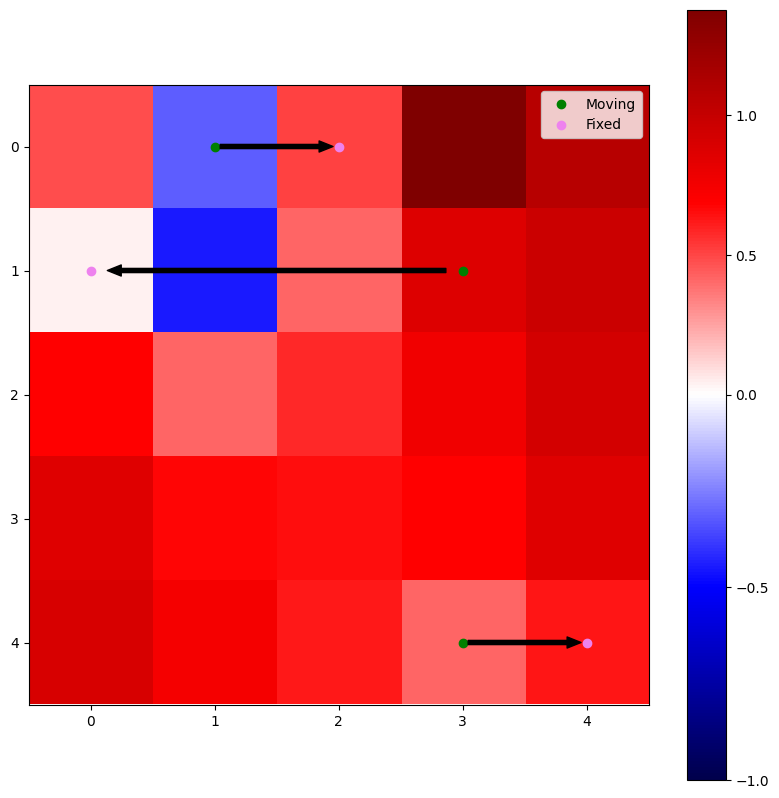

In [2]:
# Create some example correspondence points
msample = np.array([
    [0, 0, 1],
    #[0, 2, 0],
    #[0, 3, 0],
    [0, 4, 3],
    #[0, 4, 2],
    [0, 1, 3],
    #[1, 0, 1],
    #[1, 2, 0],
    #[1, 3, 0],
    #[1, 4, 4],
    #[1, 4, 2],
    #[1, 0, 4],
])
fsample = np.array([
    [0, 0, 2],
    #[0, 1, 3],
    #[0, 3, 1],
    [0, 4, 4],
    #[0, 3, 2],
    [0, 1, 0],  # Middle
    #[1, 0, 2],
    #[1, 2, 3],
    #[1, 3, 1],
    #[1, 4, 3],
    #[1, 3, 2],
    #[1, 0, 4],
])

# Create a Laplacian matrix from a sample set of correspondence points
fixed_sample = np.zeros((2, 5, 5))
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
A0 = np.zeros((A.shape[0], A.shape[1]))
A_expanded = np.block([
    [A.todense(), A0],
    [A0, A.todense()]
])
XYd = np.concatenate([Xd, Yd])
phi_xy = lgmres(A_expanded, XYd, tol = 1e-2)[0]

# Visualize values
np.set_printoptions(linewidth=1000)
print("A shape:", A.shape)
print(A.toarray())
print("Rank of A:", np.linalg.matrix_rank(A.toarray()))
print("Yd shape:", Yd.shape)
print(Yd)
print("Xd shape:", Xd.shape)
print(Xd)
print("Deformation shape:", deformation.shape)
print("Deformation:")
print(deformation)
print()

# Calculate the Jacobian determinant
jacobian_det = jacobian.sitk_jacobian_determinant(deformation)
print("Minimum Jacobian determinant:", np.min(jacobian_det))
print("Maximum Jacobian determinant:", np.max(jacobian_det))
print("Number of negative Jacobian determinants:", np.sum(jacobian_det < 0))
print("Number of zero Jacobian determinants:", np.sum(jacobian_det == 0))
print("Number of positive Jacobian determinants:", np.sum(jacobian_det > 0))

# Create a custom colormap with white at zero
norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_det.min(), -1), vcenter=0, vmax=jacobian_det.max())

plt.figure(figsize=(10, 10))
plt.imshow(jacobian_det[0], cmap='seismic', norm=norm, interpolation='nearest')
plt.colorbar()

for i in range(len(msample)):  # Draw lines connecting the points
    #plt.plot([msample[i][2], fsample[i][2]], [msample[i][1], fsample[i][1]], color='black', alpha=1)
    plt.annotate(
        '', 
        xy=(fsample[i][2], fsample[i][1]), 
        xytext=(msample[i][2], msample[i][1]), 
        arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
    )
    
plt.scatter(msample[:, 2], msample[:, 1], c='g', label='Moving')
plt.scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed')
plt.legend()
plt.show()

In [3]:
print(deformation[2, 0, :, :])

[[ 1.62990501  0.59640324 -0.99990176 -0.37642392 -0.24105065]
 [ 2.99970529  1.08191682  0.10826154 -0.09118697 -0.15628269]
 [ 1.47431315  0.84584837  0.30422356 -0.00428423 -0.16650665]
 [ 0.89696944  0.61276242  0.25056045 -0.08753382 -0.37625176]
 [ 0.6783716   0.4821777   0.16167092 -0.26848775 -0.99990176]]


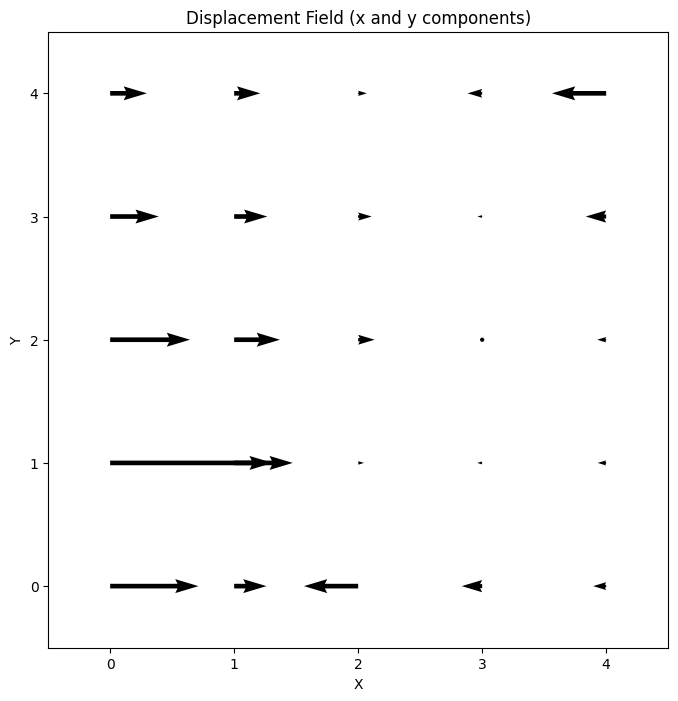

[[ 1.62990501  0.59640324 -0.99990176 -0.37642392 -0.24105065]
 [ 2.99970529  1.08191682  0.10826154 -0.09118697 -0.15628269]
 [ 1.47431315  0.84584837  0.30422356 -0.00428423 -0.16650665]
 [ 0.89696944  0.61276242  0.25056045 -0.08753382 -0.37625176]
 [ 0.6783716   0.4821777   0.16167092 -0.26848775 -0.99990176]]


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Example displacement field (3x1x5x5)
displacement_field = np.random.rand(3, 1, 5, 5)  # Replace with your actual displacement field
displacement_field = deformation


# Create a grid of points
x, y = np.meshgrid(np.arange(displacement_field.shape[3]), np.arange(displacement_field.shape[2]))

# Extract the x and y displacement components
u = displacement_field[2, 0, :, :]  # Displacement in x-direction
v = displacement_field[1, 0, :, :]  # Displacement in y-direction

# Plot the displacement vectors using a quiver plot
plt.figure(figsize=(8, 8))
plt.quiver(x, y, u, v)
plt.title('Displacement Field (x and y components)')
plt.xlim(-0.5, displacement_field.shape[3] - 0.5)
plt.ylim(-0.5, displacement_field.shape[2] - 0.5)
#plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
plt.xlabel('X')
plt.ylabel('Y')
#plt.grid()
plt.show()

print(u)

In [5]:
l_idx = laplacian.get_laplacian_index(0, 1, 1, fixed_sample.shape)
print(l_idx)

6


## Set up Scipy optimizer

In [6]:
def idx_adjacency(shape):
    idx_adj = {}
    for z in range(shape[0]):
        for y in range(shape[1]):
            for x in range(shape[2]):
                l_idx = laplacian.get_laplacian_index(z, y, x, shape)
                adjacent_indices = laplacian.get_adjacent_indices(z, y, x, shape)
                idx_adj[l_idx] = adjacent_indices
    return idx_adj

Scipy minimizer

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

https://docs.scipy.org/doc/scipy/reference/optimize.minimize-trustconstr.html

In [7]:
laplacian.get_laplacian_index(0, 0, 1, fixed_sample.shape)

1

In [8]:
import numpy as np
from scipy.optimize import minimize

# Define the matrix A and vector B
A_ = A_expanded
b_ = XYd

# Define the objective function
def objective(phi):
    return np.linalg.norm(A_ @ phi - b_)**2

y_offset = len(b_) // 2
idx_adj = idx_adjacency(fixed_sample.shape)

# Define the constraints
def jdet_constraint(phi, idx, epsilon=1e-6):
    left_idx, right_idx, up_idx, down_idx = idx_adj[idx]
    
    if left_idx is None:  # Left edge
        dxx = (phi[right_idx] - phi[idx]) / 2
        dyx = (phi[right_idx + y_offset] - phi[idx + y_offset]) / 2
    elif right_idx is None:  # Right edge
        dxx = (phi[idx] - phi[left_idx]) / 2
        dyx = (phi[idx + y_offset] - phi[left_idx + y_offset]) / 2
    else: 
        dxx = (phi[right_idx] - phi[left_idx]) / 2
        dyx = (phi[right_idx + y_offset] - phi[left_idx + y_offset]) / 2
    
    if up_idx is None:  # Top edge
        dyy = (phi[down_idx + y_offset] - phi[idx + y_offset]) / 2
        dxy = (phi[down_idx] - phi[idx]) / 2
    elif down_idx is None:  # Bottom edge
        dyy = (phi[idx + y_offset] - phi[up_idx + y_offset]) / 2
        dxy = (phi[idx] - phi[up_idx]) / 2
    else:
        dyy = (phi[down_idx + y_offset] - phi[up_idx + y_offset]) / 2
        dxy = (phi[down_idx] - phi[up_idx]) / 2
        
    return ((dxx + 1) * (dyy + 1)) - (dxy * dyx) - epsilon

# Create the constraints
constraints = []
for i in range(len(b_) // 2):
    constraints += [{'type': 'ineq', 'fun': lambda phi, i=i: jdet_constraint(phi, i)}]

# Initial guess
phi0 = phi_xy

# Solve the optimization problem
result = minimize(objective, phi0, constraints=constraints, options={'maxiter': 1000, 'disp': True}, method='SLSQP')

# Display the solutions
if result.success:
    print("phi0 error:", objective(phi0))
    print("result error:", result.fun)
    print("Solutions:")
    for i in range(len(result.x)):
        print(f"phi{i + 1} = {result.x[i]}")
else:
    print("Optimization failed:", result.message)
x_field = result.x[:len(result.x) // 2].reshape(fixed_sample.shape)
y_field = result.x[len(result.x) // 2:].reshape(fixed_sample.shape)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5988450840308952
            Iterations: 104
            Function evaluations: 10664
            Gradient evaluations: 104
phi0 error: 0.0010806190828808791
result error: 0.5988450840308952
Solutions:
phi1 = 1.4518643679781025
phi2 = 0.7056303553019436
phi3 = -0.5745319387776407
phi4 = 0.08718127658949365
phi5 = 0.2515062394110981
phi6 = 2.4874888703267035
phi7 = 1.15251472920121
phi8 = 0.4612166418616743
phi9 = 0.3468658400069742
phi10 = 0.30952886925047185
phi11 = 1.4883745566187705
phi12 = 1.045083196344298
phi13 = 0.6454891732138269
phi14 = 0.3948639222795019
phi15 = 0.24176432247146082
phi16 = 1.1176344461638406
phi17 = 0.8971414699976836
phi18 = 0.5899738696604431
phi19 = 0.25655339383617726
phi20 = -0.07309381299044214
phi21 = 0.9759062169330047
phi22 = 0.8040054387956864
phi23 = 0.4936914253292856
phi24 = 0.009492767422617633
phi25 = -0.9129961311091188
phi26 = 1.2502866523987357
phi27 =

SITK deformation shape: (2, 5, 5, 3)
Minimum Jacobian determinant: -0.44572187092786364
Maximum Jacobian determinant: 1.3794255550717325
Number of negative Jacobian determinants: 2
Number of zero Jacobian determinants: 0
Number of positive Jacobian determinants: 48
Jacobian det at 0, 1, 1: -0.44572187092786364
Jacobian det at 0, 0, 1: -0.314903387796587


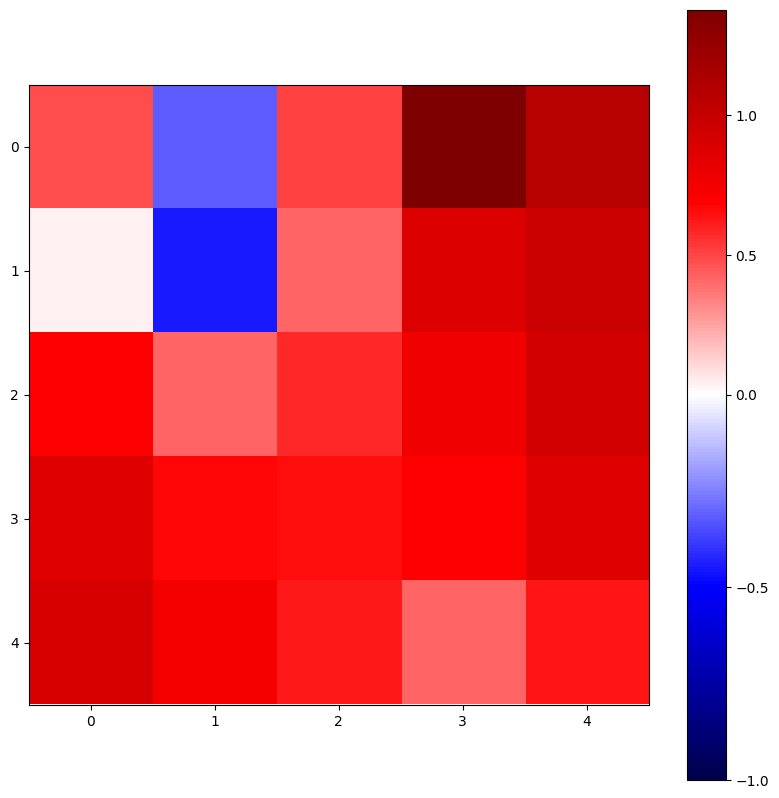

In [9]:
# Set deformation field from result
z_field = np.zeros(fixed_sample.shape)
def_field = deformation
#print(def_field.shape)

# Calculate the Jacobian determinant
jacobian_det = jacobian.sitk_jacobian_determinant(def_field)
print("Minimum Jacobian determinant:", np.min(jacobian_det))
print("Maximum Jacobian determinant:", np.max(jacobian_det))
print("Number of negative Jacobian determinants:", np.sum(jacobian_det < 0))
print("Number of zero Jacobian determinants:", np.sum(jacobian_det == 0))
print("Number of positive Jacobian determinants:", np.sum(jacobian_det > 0))

# Create a custom colormap with white at zero
norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_det.min(), -1), vcenter=0, vmax=jacobian_det.max())

print("Jacobian det at 0, 1, 1:", jacobian_det[0, 1, 1])
print("Jacobian det at 0, 0, 1:", jacobian_det[0, 0, 1])

plt.figure(figsize=(10, 10))
plt.imshow(jacobian_det[0], cmap='seismic', norm=norm, interpolation='nearest')
plt.colorbar()
plt.show()


(3, 2, 5, 5)
SITK deformation shape: (2, 5, 5, 3)
Minimum Jacobian determinant: 1.000650161576619e-06
Maximum Jacobian determinant: 1.4175007719512036
Number of negative Jacobian determinants: 0
Number of zero Jacobian determinants: 0
Number of positive Jacobian determinants: 50
Jacobian det at 0, 1, 1: 1.002063918720958e-06
Jacobian det at 0, 0, 1: 1.000650161576619e-06


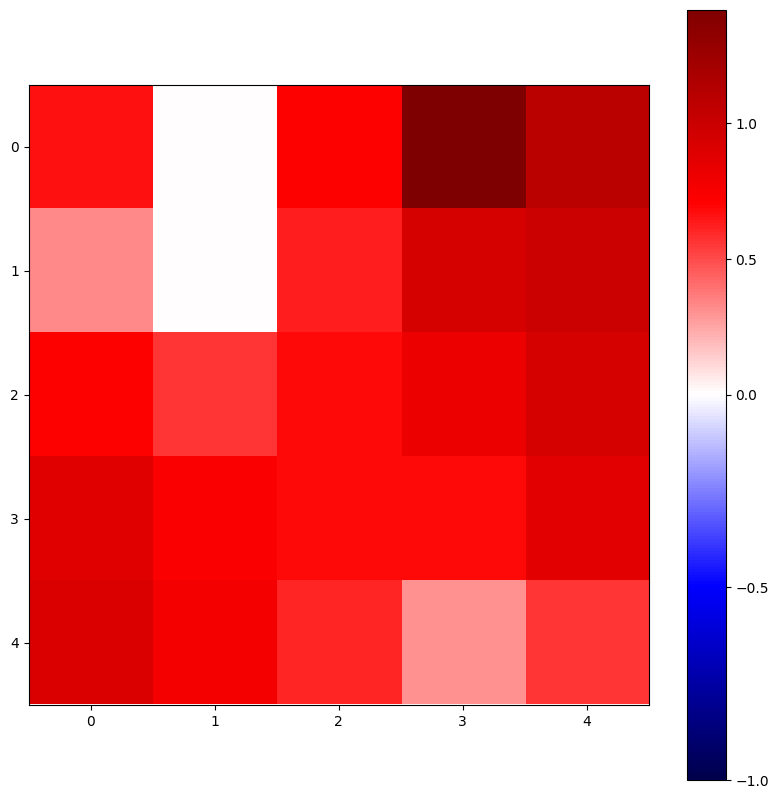

In [10]:
# Set deformation field from result
z_field = np.zeros(fixed_sample.shape)
def_field = np.stack([z_field, y_field, x_field], axis=0)
print(def_field.shape)

# Calculate the Jacobian determinant
jacobian_det = jacobian.sitk_jacobian_determinant(def_field)
print("Minimum Jacobian determinant:", np.min(jacobian_det))
print("Maximum Jacobian determinant:", np.max(jacobian_det))
print("Number of negative Jacobian determinants:", np.sum(jacobian_det < 0))
print("Number of zero Jacobian determinants:", np.sum(jacobian_det == 0))
print("Number of positive Jacobian determinants:", np.sum(jacobian_det > 0))

# Create a custom colormap with white at zero
norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_det.min(), -1), vcenter=0, vmax=jacobian_det.max())

print("Jacobian det at 0, 1, 1:", jacobian_det[0, 1, 1])
print("Jacobian det at 0, 0, 1:", jacobian_det[0, 0, 1])

plt.figure(figsize=(10, 10))
plt.imshow(jacobian_det[0], cmap='seismic', norm=norm, interpolation='nearest')
plt.colorbar()
plt.show()


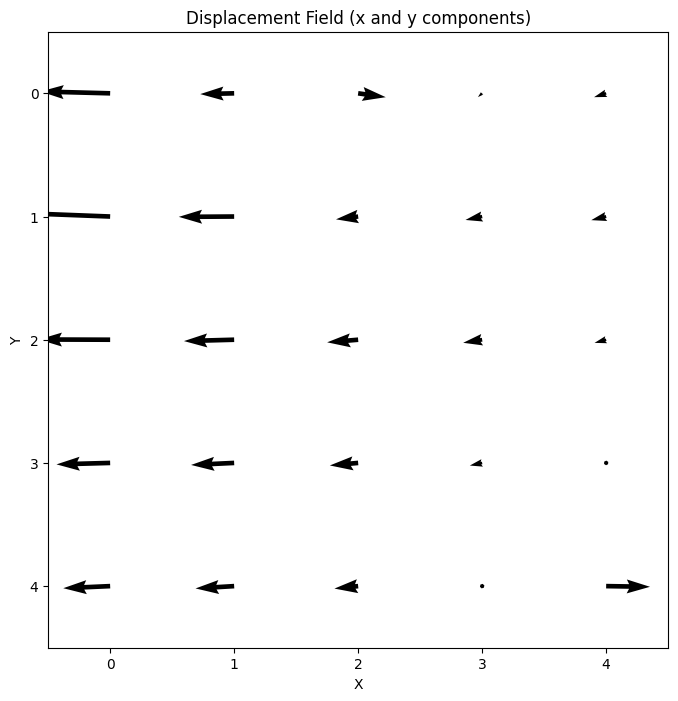

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Example displacement field (3x1x5x5)
displacement_field = np.random.rand(3, 1, 5, 5)  # Replace with your actual displacement field
displacement_field = def_field


# Create a grid of points
x, y = np.meshgrid(np.arange(displacement_field.shape[3]), np.arange(displacement_field.shape[2]))

# Extract the x and y displacement components
u = -displacement_field[2, 0, :, :]  # Displacement in x-direction
v = displacement_field[1, 0, :, :]  # Displacement in y-direction

# Plot the displacement vectors using a quiver plot
plt.figure(figsize=(8, 8))
plt.quiver(x, y, u, v)
plt.title('Displacement Field (x and y components)')
plt.xlim(-0.5, displacement_field.shape[3] - 0.5)
plt.ylim(-0.5, displacement_field.shape[2] - 0.5)
plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
plt.xlabel('X')
plt.ylabel('Y')
#plt.grid()
plt.show()

Do this just for a good case

fdata.shape (2, 5, 5)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.04747962951660156s
Computing dy
dy calculated in 0.04836153984069824s
Computing dx
dx calculated in 0.04909706115722656s
A shape: (50, 50)
[[ 3. -1.  0. ...  0.  0.  0.]
 [-1.  4. -1. ...  0.  0.  0.]
 [ 0.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  4. -1.  0.]
 [ 0.  0.  0. ... -1.  4. -1.]
 [ 0.  0.  0. ...  0. -1.  3.]]
Rank of A: 50
Yd shape: (50,)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Xd shape: (50,)
[ 0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Deformation shape: (3, 2, 5, 5)
Deformation:
[[[[ 0.          0.          0.          

/tmp/ipykernel_1955455/3773044062.py:42: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  phi_xy = lgmres(A_expanded, XYd, tol = 1e-2)[0]


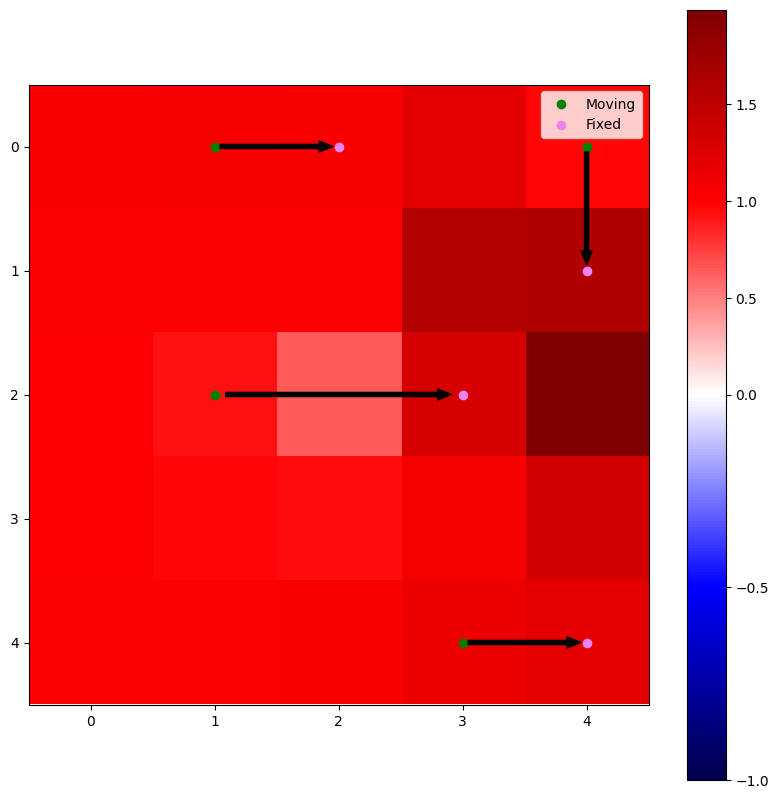

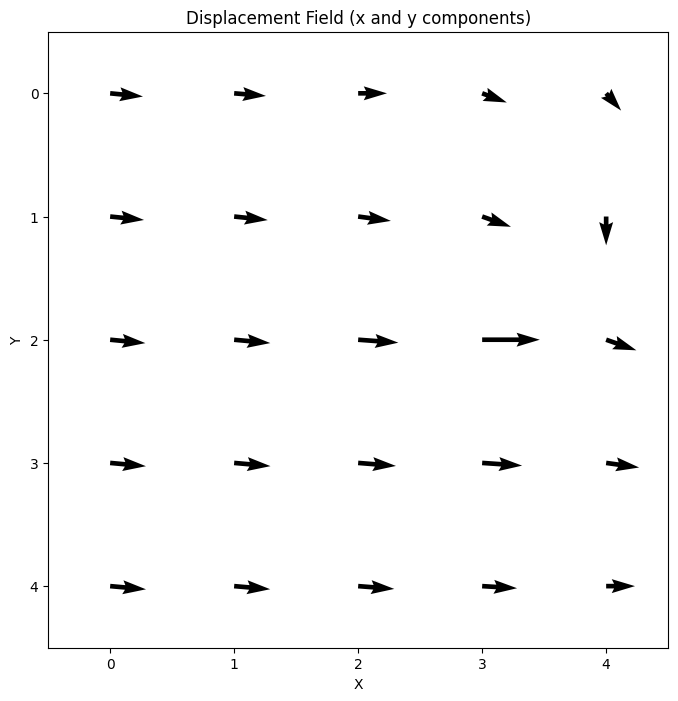

[[ 1.13825856  1.10301055  0.99997134  0.85522737  0.5200507 ]
 [ 1.17506716  1.16536958  1.13580003  0.99958805 -0.        ]
 [ 1.22195106  1.25402512  1.39348093  1.99994267  1.04865325]
 [ 1.240434    1.2604781   1.31141423  1.38620177  1.14435627]
 [ 1.24303663  1.24975127  1.25283023  1.21094137  0.99997134]]
[[-0.11087271 -0.09051316  0.         -0.3184239  -0.5997036 ]
 [-0.11985362 -0.12329135 -0.15240405 -0.35667878 -0.99993051]
 [-0.11783358 -0.11623668 -0.10286657  0.         -0.36758722]
 [-0.11356094 -0.11126864 -0.10495163 -0.09410164 -0.15908564]
 [-0.11073148 -0.10717229 -0.0972024  -0.07289751  0.        ]]


In [12]:
# Create some example correspondence points
msample = np.array([
    [0, 0, 1],
    #[0, 2, 0],
    #[0, 3, 0],
    [0, 4, 3],
    #[0, 4, 2],
    [0, 2, 1],
    [0, 0, 4],
    #[1, 0, 1],
    #[1, 2, 0],
    #[1, 3, 0],
    #[1, 4, 4],
    #[1, 4, 2],
    #[1, 0, 4],
])
fsample = np.array([
    [0, 0, 2],
    #[0, 1, 3],
    #[0, 3, 1],
    [0, 4, 4],
    #[0, 3, 2],
    [0, 2, 3],  # Middle
    [0, 1, 4],
    #[1, 0, 2],
    #[1, 2, 3],
    #[1, 3, 1],
    #[1, 4, 3],
    #[1, 3, 2],
    #[1, 0, 4],
])

# Create a Laplacian matrix from a sample set of correspondence points
fixed_sample = np.zeros((2, 5, 5))
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
A0 = np.zeros((A.shape[0], A.shape[1]))
A_expanded = np.block([
    [A.todense(), A0],
    [A0, A.todense()]
])
XYd = np.concatenate([Xd, Yd])
phi_xy = lgmres(A_expanded, XYd, tol = 1e-2)[0]

# Visualize values
np.set_printoptions(linewidth=1000)
print("A shape:", A.shape)
print(A.toarray())
print("Rank of A:", np.linalg.matrix_rank(A.toarray()))
print("Yd shape:", Yd.shape)
print(Yd)
print("Xd shape:", Xd.shape)
print(Xd)
print("Deformation shape:", deformation.shape)
print("Deformation:")
print(deformation)
print()

# Calculate the Jacobian determinant
jacobian_det = jacobian.sitk_jacobian_determinant(deformation)
print("Minimum Jacobian determinant:", np.min(jacobian_det))
print("Maximum Jacobian determinant:", np.max(jacobian_det))
print("Number of negative Jacobian determinants:", np.sum(jacobian_det < 0))
print("Number of zero Jacobian determinants:", np.sum(jacobian_det == 0))
print("Number of positive Jacobian determinants:", np.sum(jacobian_det > 0))

# Create a custom colormap with white at zero
norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_det.min(), -1), vcenter=0, vmax=jacobian_det.max())

plt.figure(figsize=(10, 10))
plt.imshow(jacobian_det[0], cmap='seismic', norm=norm, interpolation='nearest')
plt.colorbar()

for i in range(len(msample)):  # Draw lines connecting the points
    #plt.plot([msample[i][2], fsample[i][2]], [msample[i][1], fsample[i][1]], color='black', alpha=1)
    plt.annotate(
        '', 
        xy=(fsample[i][2], fsample[i][1]), 
        xytext=(msample[i][2], msample[i][1]), 
        arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
    )
    
plt.scatter(msample[:, 2], msample[:, 1], c='g', label='Moving')
plt.scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed')
plt.legend()
plt.show()


# Example displacement field (3x1x5x5)
displacement_field = deformation


# Create a grid of points
x, y = np.meshgrid(np.arange(displacement_field.shape[3]), np.arange(displacement_field.shape[2]))

# Extract the x and y displacement components
u = -displacement_field[2, 0, :, :]  # Displacement in x-direction
v = displacement_field[1, 0, :, :]  # Displacement in y-direction

# Plot the displacement vectors using a quiver plot
plt.figure(figsize=(8, 8))
plt.quiver(x, y, u, v)
plt.title('Displacement Field (x and y components)')
plt.xlim(-0.5, displacement_field.shape[3] - 0.5)
plt.ylim(-0.5, displacement_field.shape[2] - 0.5)
plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
plt.xlabel('X')
plt.ylabel('Y')
#plt.grid()
plt.show()

print(u)
print(v)